**loading data and libraries:**

In [8]:
import pickle

pickle_file_path = '/content/ass3.pickle'  # Update with the actual file path
with open(pickle_file_path, 'rb') as file:
    data_all = pickle.load(file)



In [26]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

**data analysis:**

In [10]:
data = data_all["train"]

print("\nData shape:")
print(data.shape)
print("\nFirst 10 rows:")
print(data[:10])


# Summary statistics of the numerical features
print("\nSummary statistics:")
print(data.describe())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Correlation between features
print("\nCorrelation matrix:")
print(data.corr())


Data shape:
(12384, 9)

First 10 rows:
           f0    f1        f2        f3      f4        f5     f6      f7  \
14981  4.0391  15.0  6.297710  0.992366   334.0  2.549618  32.72 -116.99   
6614   4.7241  46.0  5.375758  0.954545   753.0  2.281818  34.17 -118.10   
14233  3.3553   7.0  5.229213  1.101124  1304.0  2.930337  32.70 -117.01   
1802   1.3929  52.0  5.000000  0.953488   126.0  2.930233  37.92 -122.36   
6030   1.6006  52.0  4.427083  1.017361  1246.0  2.163194  34.07 -117.75   
5729   3.5781  37.0  4.828175  1.072572  2099.0  2.240128  34.17 -118.23   
3519   4.3333  33.0  5.767956  1.058011   960.0  2.651934  34.25 -118.49   
5951   4.3145  31.0  6.465347  1.049505  1021.0  3.369637  34.13 -117.85   
10701  3.6484  16.0  3.456268  1.056851  1738.0  2.533528  33.61 -117.70   
19461  6.4788  25.0  7.278215  1.007874  1060.0  2.782152  37.69 -120.99   

       target  
14981   1.695  
6614    2.796  
14233   1.322  
1802    1.042  
6030    1.462  
5729    3.667  
3519    2.3

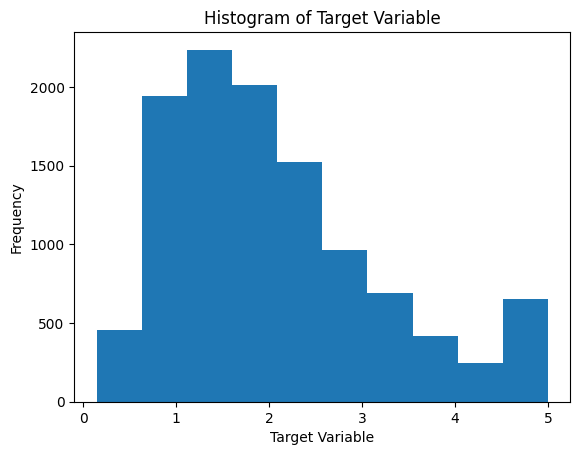

In [ ]:
# Plot histogram of the target variable
plt.hist(y_train, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Histogram of Target Variable')
plt.show()

**imputation and regressor model fitting:**

In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'XGBoost Regressor': XGBRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'SVR': SVR(),
    'Elastic Net': ElasticNet(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Passive Aggressive Regressor': PassiveAggressiveRegressor()
}

imputation_methods = {
    'Mean Imputation': SimpleImputer(strategy='mean'),
    'Median Imputation': SimpleImputer(strategy='median'),
    'Most Frequent Imputation': SimpleImputer(strategy='most_frequent'),
    'Constant Imputation': SimpleImputer(strategy='constant', fill_value=0),
    'Iterative Imputation': IterativeImputer()
}

In [15]:
best_model = None
best_imputation = None
min_mse = float('inf')

# Iterate over imputation methods
for imputation_name, imputation_method in imputation_methods.items():
    print(f'Imputation Method: {imputation_name}')
    print('--------------------------------------------')

    # Impute missing values in train set
    X_train_imputed = imputation_method.fit_transform(data_all["train"].drop("target", axis=1))
    y_train = data_all["train"]["target"].values

    # Impute missing values in dev set
    X_dev_imputed = imputation_method.transform(data_all["dev"].drop("target", axis=1))
    y_dev = data_all["dev"]["target"].values

    # Impute missing values in test set
    X_test_imputed = imputation_method.transform(data_all["test"].drop("target", axis=1))
    y_test = data_all["test"]["target"].values

    # Iterate over models
    for model_name, model in models.items():
        print(f'Model: {model_name}')

        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train_imputed, y_train, cv=KFold(n_splits=5), scoring='neg_mean_squared_error')
        rmse_scores = [sqrt(-score) for score in cv_scores]
        mean_rmse = np.mean(rmse_scores)
        print(f'Cross-Validation RMSE: {mean_rmse}')

        # Fit the model on the training data
        model.fit(X_train_imputed, y_train)

        # Make predictions on the development set
        y_pred = model.predict(X_dev_imputed)

        # Calculate RMSE, MSE, MAE score
        rmse = sqrt(mean_squared_error(y_dev, y_pred))
        print(f'RMSE: {rmse}')

        mae = mean_absolute_error(y_dev, y_pred)
        print(f'MAE: {mae}')

        mse = mean_squared_error(y_dev, y_pred)
        print(f'MSE: {mse}')

        r2 = r2_score(y_dev, y_pred)
        print(f'R-squared: {r2}')

        print('--------------------------------------------')

        # Check if current model has lower MSE
        if mse < min_mse:
            min_mse = mse
            best_model = model_name
            best_imputation = imputation_name

    print('============================================')

print(f"Best Model and Imputation Method: {best_model} with {best_imputation}")

Imputation Method: Mean Imputation
--------------------------------------------
Model: Linear Regression
Cross-Validation RMSE: 0.743699026558998
RMSE: 0.7231212449524678
MAE: 0.5231571750489653
MSE: 0.5229043349016068
R-squared: 0.6008414936534727
--------------------------------------------
Model: Decision Tree Regressor
Cross-Validation RMSE: 0.7646867056695095
RMSE: 0.763192619202984
MAE: 0.49398295542635656
MSE: 0.5824629740059108
R-squared: 0.5553774654591392
--------------------------------------------
Model: Random Forest Regressor
Cross-Validation RMSE: 0.5370968049821432
RMSE: 0.5192102294437598
MAE: 0.3430841153343025
MSE: 0.26957926235904167
R-squared: 0.7942169369747503
--------------------------------------------
Model: Gradient Boosting Regressor
Cross-Validation RMSE: 0.5594388865971786
RMSE: 0.5438336037287937
MAE: 0.3735499121737498
MSE: 0.2957549885446467
R-squared: 0.7742357223062052
--------------------------------------------
Model: XGBoost Regressor
Cross-Validat

the model + imputation method that yielded the best MSE score were XGBoost and Median Imputation.

now for them we will perform **hyper-parameter tuning:**

In [23]:
# Impute missing values with median imputation
imputation_method = SimpleImputer(strategy='median')
X_train_imputed = imputation_method.fit_transform(data_all["train"].drop("target", axis=1))
y_train = data_all["train"]["target"].values

X_dev_imputed = imputation_method.transform(data_all["dev"].drop("target", axis=1))
y_dev = data_all["dev"]["target"].values

# Fine-tuning XGBoost with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

model = XGBRegressor()

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_imputed, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print('Best Parameters:')
print(best_params)

print('Best Model:')
print(best_model)

# Fit the best model on the development/validation data
best_model.fit(X_train_imputed, y_train)

# Make predictions on the development/validation data
y_pred = best_model.predict(X_dev_imputed)

# Calculate RMSE, MSE, MAE score
mse = mean_squared_error(y_dev, y_pred)
print(f'MSE: {mse}')

rmse = sqrt(mean_squared_error(y_dev, y_pred))
print(f'RMSE: {rmse}')

mae = mean_absolute_error(y_dev, y_pred)
print(f'MAE: {mae}')

r2 = r2_score(y_dev, y_pred)
print(f'R-squared: {r2}')

Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best Model:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
MSE: 0.20889252322962024
RMSE: 0.4570476159325418
MAE: 0.29911788624212376
R-squared: 0.8405420992063835


In [24]:
# Fit the best model on the combined training and development/validation data
best_model.fit(np.concatenate((X_train_imputed, X_dev_imputed)), np.concatenate((y_train, y_dev)))

# Make predictions on the test data
y_pred_test = best_model.predict(X_test_imputed)

# Calculate MSE score on the test data
mse_test = mean_squared_error(y_test, y_pred_test)
print(f'Test MSE: {mse_test}')

# Calculate RMSE score on the test data
rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))
print(f'Test RMSE: {rmse_test}')

# Calculate MAE score on the test data
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test MAE: {mae_test}')

# Calculate R-squared score on the test data
r2_test = r2_score(y_test, y_pred_test)
print(f'Test R-squared: {r2_test}')

Test MSE: 0.20303154186571634
Test RMSE: 0.4505902150132827
Test MAE: 0.29134156866928634
Test R-squared: 0.8544513139406297


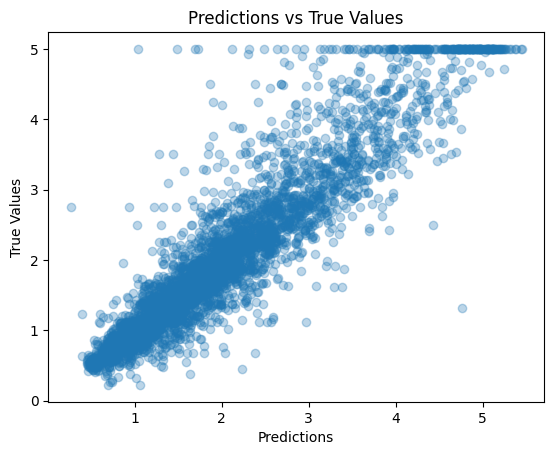

In [29]:
plt.scatter(y_pred_test, y_test, alpha=0.3)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Predictions vs True Values')
plt.show()

We used MSE metric, and we checked different models, and chose the one with the lowest value of MSE.
After choosing the best model we checked what it's best hyper-parameters, trained the model a few times, each time using a different one and picked the one which gives the best result.
We checked what the error on the validation based on the hyper-parameters, and after finding the best ones we checked the performance on the test.

the model and imputation method that yielded the best MSE score were XGBoost and Median Imputation.

after hyper-parameter tuning and training on both the dev and the train data sets, the final models results on the test set were:

Test MSE: 0.20303154186571634
Test RMSE: 0.4505902150132827
Test MAE: 0.29134156866928634
Test R-squared: 0.8544513139406297